# CORA
**Explaining simple 2-layer GCN model predictions on CORA dataset**

In [ ]:
!pip install torch-geometric

# Creating and training model

In [ ]:
import torch
from torch.nn import ReLU, LogSoftmax
from torch.nn.functional import nll_loss
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import Planetoid

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = Planetoid(root="./data/cora", name="cora")
data = dataset[0].to(device)

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 64), "x, edge_index -> x"),
    ReLU(inplace=True),
    (GCNConv(64, dataset.num_classes), "x, edge_index -> x"),
    LogSoftmax(dim=1)
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
acc_train = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
acc_test = (pred[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print(f'Training acc: {acc_train:.2f}, test acc: {acc_test:.2f}')

Training acc: 1.00, test acc: 0.81


# Model prediction explanation

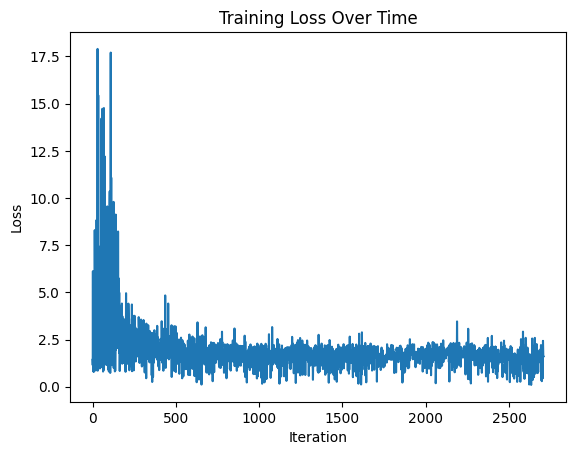

Prediction correct: True
Node label: 3
Node prediction: 3


In [ ]:
from torch_geometric.explain import Explainer, PGExplainer
import matplotlib.pyplot as plt

model = model.to(device)

data = data.to(device)

edge_index = data.edge_index.to(device)

pg_explainer = PGExplainer(epochs=1, lr=0.001)

explainer = Explainer(
    model=model,
    algorithm=pg_explainer.to(device),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)


training_losses = []
for epoch in range(1):
    for index in range(data.num_nodes):
        loss = explainer.algorithm.train(epoch, model, data.x, edge_index, target=data.y, index=index)
        training_losses.append(loss)

plt.plot(training_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()


node_index = 0
target_label = data.y[node_index].item()

explanation = explainer(data.x, edge_index, index=node_index, target=target_label)

print(f'Prediction correct: {explanation.validate()}')
print(f'Node label: {data.y[node_index].item()}')
print(f'Node prediction: {pred[node_index].item()}')

In [ ]:
node_index = 0
target_label = data.y[node_index].item()

explanation = explainer(data.x, edge_index, index=node_index, target=target_label)

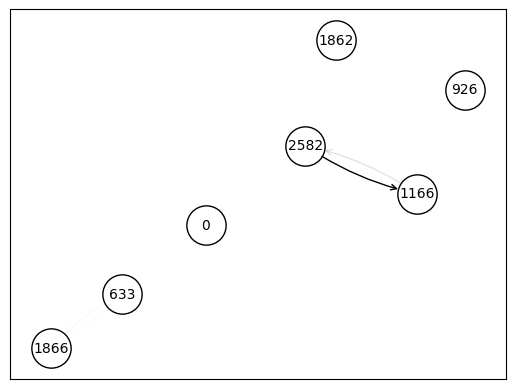

In [ ]:
explanation.visualize_graph(backend="networkx")

In [ ]:
print(explanation.edge_mask)

tensor([1.5472e-22, 0.0000e+00, 2.2572e-22,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], device='cuda:0')


In [ ]:
import torch
import numpy as np
from torch.nn import ReLU, Sigmoid
from torch.nn.functional import binary_cross_entropy
from torch_geometric.nn import Sequential, GCNConv
from torch_geometric.datasets import HeterophilousGraphDataset
import os

np.random.seed(0)
torch.manual_seed(0)
device = torch.device("cpu")
dataset = HeterophilousGraphDataset(root="./data/minesweeper", name="minesweeper")
data = dataset[0].to(device)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.train_mask[(data.y == 1).nonzero(as_tuple=True)] = True
data.train_mask[np.random.choice((data.y == 0).nonzero(as_tuple=True)[0].cpu().numpy(), 4000)] = True

model = Sequential("x, edge_index", [
    (GCNConv(dataset.num_features, 8), "x, edge_index -> x"),
    ReLU(inplace=True),
    (GCNConv(8, 1), "x, edge_index -> x"),
    Sigmoid()
]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for _ in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].float().unsqueeze(1))
    loss.backward()
    optimizer.step()

model.eval()
pred = model(data.x, data.edge_index)
acc_train = (pred.round().long()[data.train_mask] == data.y[data.train_mask].unsqueeze(1)).sum().item() / data.train_mask.sum().item()
acc = (pred.round().long() == data.y.unsqueeze(1)).sum().item() / data.num_nodes
print(f'Training acc: {acc_train:.2f}, test acc: {acc:.2f}')

Training acc: 0.68, test acc: 0.74


In [ ]:
from torch_geometric.explain import Explainer, PGExplainer


edge_index = data.edge_index.to(device)

pg_explainer = PGExplainer(epochs=1, lr=0.001)

explainer = Explainer(
    model=model,
    algorithm=pg_explainer.to(device),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='raw',
    ),
    threshold_config=dict(threshold_type='topk', value=10),
)


print(f'Target labels: {data.y}')

training_losses = []
for epoch in range(1):
    for index in range(data.num_nodes):
        loss = explainer.algorithm.train(epoch, model, data.x, edge_index, target=data.y, index=index)
        training_losses.append(loss)



Target labels: tensor([0, 1, 0,  ..., 0, 0, 0])


NameError: ignored

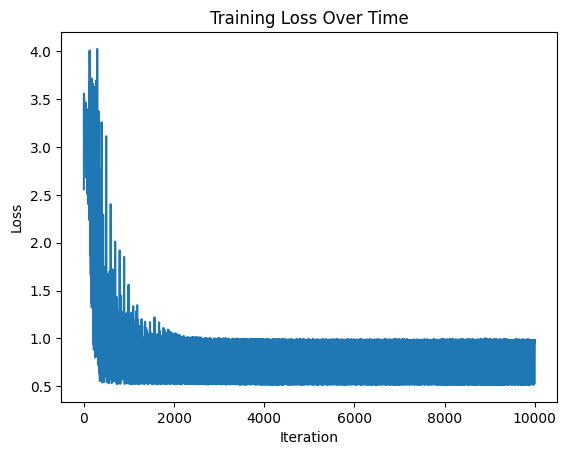

Prediction correct: True
Node label: 0
Node prediction: 0.14471732079982758


In [ ]:
from matplotlib import pyplot as plt

plt.plot(training_losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()


node_index = 0
target_label = data.y[node_index].item()

explanation = explainer(data.x, edge_index, index=node_index, target=target_label)

print(f'Prediction correct: {explanation.validate()}')
print(f'Node label: {data.y[node_index].item()}')
print(f'Node prediction: {pred[node_index].item()}')

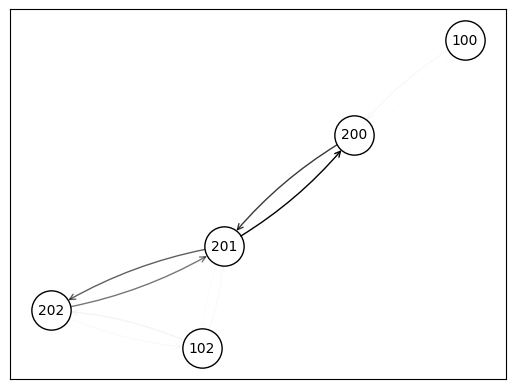

In [ ]:
explanation.visualize_graph(backend="networkx")